### Main points
- Build duration prediction model with new york city taxi dataset
- Log parameters, tag with mlflow
- Parameter tuning with `hyperopt`
- Autolog with mlflow

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [3]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [4]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [5]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.775464354743487

C:\Users\RD_3\anaconda3\envs\torch\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\RD_3\anaconda3\envs\torch\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


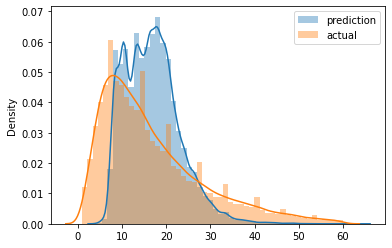

In [6]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [7]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [8]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [9]:
len(df_train), len(df_val)

(73908, 61921)

In [10]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [11]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [12]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.479614645724615

In [14]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [19]:
with mlflow.start_run():
    mlflow.set_tag("developer", "godwin")
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path", "./data/green_tripdata_2021-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

In [21]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [23]:
train, valid = xgb.DMatrix(X_train, label=y_train), xgb.DMatrix(X_val, label=y_val)

In [24]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        
        mlflow.log_metric("rmse", rmse)
    return {'loss': rmse, "status": STATUS_OK}

In [26]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), #exp(-3)-exp(0)
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=Trials()
)

[10:09:47] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.03039                                                                                           
[1]	validation-rmse:15.49633                                                                                           
[2]	validation-rmse:13.48194                                                                                           
[3]	validation-rmse:11.89676                                                                                           
[4]	validation-rmse:10.66019                                                                                           
[5]	validation-rmse:9.70625                                                                                            
[6]	validation-rmse:8.97676                                                                                            
[7]	v

[66]	validation-rmse:6.65663                                                                                           
[67]	validation-rmse:6.65649                                                                                           
[68]	validation-rmse:6.65594                                                                                           
[69]	validation-rmse:6.65594                                                                                           
[70]	validation-rmse:6.65577                                                                                           
[71]	validation-rmse:6.65585                                                                                           
[72]	validation-rmse:6.65577                                                                                           
[73]	validation-rmse:6.65551                                                                                           
[74]	validation-rmse:6.65544            

[134]	validation-rmse:6.64926                                                                                          
[135]	validation-rmse:6.64883                                                                                          
[136]	validation-rmse:6.64876                                                                                          
[137]	validation-rmse:6.64883                                                                                          
[138]	validation-rmse:6.64872                                                                                          
[139]	validation-rmse:6.64881                                                                                          
[140]	validation-rmse:6.64851                                                                                          
[141]	validation-rmse:6.64831                                                                                          
[142]	validation-rmse:6.64833           

[202]	validation-rmse:6.64807                                                                                          
[203]	validation-rmse:6.64794                                                                                          
[204]	validation-rmse:6.64796                                                                                          
[205]	validation-rmse:6.64779                                                                                          
[206]	validation-rmse:6.64768                                                                                          
[207]	validation-rmse:6.64767                                                                                          
[208]	validation-rmse:6.64749                                                                                          
[209]	validation-rmse:6.64754                                                                                          
[210]	validation-rmse:6.64751           

[57]	validation-rmse:6.47742                                                                                           
[58]	validation-rmse:6.47431                                                                                           
[59]	validation-rmse:6.47363                                                                                           
[60]	validation-rmse:6.47205                                                                                           
[61]	validation-rmse:6.47099                                                                                           
[62]	validation-rmse:6.46960                                                                                           
[63]	validation-rmse:6.47078                                                                                           
[64]	validation-rmse:6.47014                                                                                           
[65]	validation-rmse:6.46897            

[125]	validation-rmse:6.42675                                                                                          
[126]	validation-rmse:6.42589                                                                                          
[127]	validation-rmse:6.42506                                                                                          
[128]	validation-rmse:6.42519                                                                                          
[129]	validation-rmse:6.42470                                                                                          
[130]	validation-rmse:6.42452                                                                                          
[131]	validation-rmse:6.42573                                                                                          
[132]	validation-rmse:6.42274                                                                                          
[133]	validation-rmse:6.42264           

[193]	validation-rmse:6.40730                                                                                          
[194]	validation-rmse:6.40731                                                                                          
[195]	validation-rmse:6.40904                                                                                          
[196]	validation-rmse:6.40841                                                                                          
[197]	validation-rmse:6.40833                                                                                          
[198]	validation-rmse:6.40831                                                                                          
[199]	validation-rmse:6.40837                                                                                          
[200]	validation-rmse:6.40869                                                                                          
[201]	validation-rmse:6.40850           

[261]	validation-rmse:6.40283                                                                                          
[262]	validation-rmse:6.40339                                                                                          
[263]	validation-rmse:6.40369                                                                                          
[264]	validation-rmse:6.40351                                                                                          
[265]	validation-rmse:6.40337                                                                                          
[266]	validation-rmse:6.40419                                                                                          
[267]	validation-rmse:6.40381                                                                                          
[268]	validation-rmse:6.40379                                                                                          
[269]	validation-rmse:6.40428           

[53]	validation-rmse:6.65388                                                                                           
[54]	validation-rmse:6.65337                                                                                           
[55]	validation-rmse:6.65264                                                                                           
[56]	validation-rmse:6.65234                                                                                           
[57]	validation-rmse:6.65209                                                                                           
[58]	validation-rmse:6.65175                                                                                           
[59]	validation-rmse:6.65166                                                                                           
[60]	validation-rmse:6.65121                                                                                           
[61]	validation-rmse:6.65081            

[121]	validation-rmse:6.63969                                                                                          
[122]	validation-rmse:6.63976                                                                                          
[123]	validation-rmse:6.63927                                                                                          
[124]	validation-rmse:6.63933                                                                                          
[125]	validation-rmse:6.63937                                                                                          
[126]	validation-rmse:6.63929                                                                                          
[127]	validation-rmse:6.63929                                                                                          
[128]	validation-rmse:6.63925                                                                                          
[129]	validation-rmse:6.63914           

[189]	validation-rmse:6.63618                                                                                          
[190]	validation-rmse:6.63613                                                                                          
[191]	validation-rmse:6.63633                                                                                          
[192]	validation-rmse:6.63608                                                                                          
[193]	validation-rmse:6.63603                                                                                          
[194]	validation-rmse:6.63586                                                                                          
[195]	validation-rmse:6.63526                                                                                          
[196]	validation-rmse:6.63520                                                                                          
[197]	validation-rmse:6.63511           

[257]	validation-rmse:6.63347                                                                                          
[258]	validation-rmse:6.63332                                                                                          
[259]	validation-rmse:6.63335                                                                                          
[260]	validation-rmse:6.63335                                                                                          
[261]	validation-rmse:6.63337                                                                                          
[262]	validation-rmse:6.63328                                                                                          
[263]	validation-rmse:6.63312                                                                                          
[264]	validation-rmse:6.63322                                                                                          
[265]	validation-rmse:6.63314           

[325]	validation-rmse:6.63338                                                                                          
[326]	validation-rmse:6.63339                                                                                          
[327]	validation-rmse:6.63381                                                                                          
[328]	validation-rmse:6.63357                                                                                          
[329]	validation-rmse:6.63368                                                                                          
[330]	validation-rmse:6.63378                                                                                          
[331]	validation-rmse:6.63373                                                                                          
[332]	validation-rmse:6.63371                                                                                          
[333]	validation-rmse:6.63360           

[43]	validation-rmse:6.46228                                                                                           
[44]	validation-rmse:6.45912                                                                                           
[45]	validation-rmse:6.46004                                                                                           
[46]	validation-rmse:6.46013                                                                                           
[47]	validation-rmse:6.45790                                                                                           
[48]	validation-rmse:6.46146                                                                                           
[49]	validation-rmse:6.45776                                                                                           
[50]	validation-rmse:6.46096                                                                                           
[51]	validation-rmse:6.46100            

[111]	validation-rmse:6.42680                                                                                          
[112]	validation-rmse:6.42652                                                                                          
[113]	validation-rmse:6.42575                                                                                          
[114]	validation-rmse:6.42532                                                                                          
[115]	validation-rmse:6.42625                                                                                          
[116]	validation-rmse:6.42540                                                                                          
[117]	validation-rmse:6.42498                                                                                          
[118]	validation-rmse:6.42304                                                                                          
[119]	validation-rmse:6.42223           

[6]	validation-rmse:6.64801                                                                                            
[7]	validation-rmse:6.63892                                                                                            
[8]	validation-rmse:6.63381                                                                                            
[9]	validation-rmse:6.63207                                                                                            
[10]	validation-rmse:6.62875                                                                                           
[11]	validation-rmse:6.62393                                                                                           
[12]	validation-rmse:6.61581                                                                                           
[13]	validation-rmse:6.60900                                                                                           
[14]	validation-rmse:6.60466            

[74]	validation-rmse:6.45601                                                                                           
[75]	validation-rmse:6.45334                                                                                           
[76]	validation-rmse:6.45188                                                                                           
[77]	validation-rmse:6.44972                                                                                           
[78]	validation-rmse:6.44808                                                                                           
[79]	validation-rmse:6.44871                                                                                           
[80]	validation-rmse:6.44779                                                                                           
[81]	validation-rmse:6.44729                                                                                           
[82]	validation-rmse:6.44576            

[142]	validation-rmse:6.40565                                                                                          
[143]	validation-rmse:6.40553                                                                                          
[144]	validation-rmse:6.40574                                                                                          
[145]	validation-rmse:6.40611                                                                                          
[146]	validation-rmse:6.39997                                                                                          
[147]	validation-rmse:6.39615                                                                                          
[148]	validation-rmse:6.39487                                                                                          
[149]	validation-rmse:6.39434                                                                                          
[150]	validation-rmse:6.39371           

[210]	validation-rmse:6.36992                                                                                          
[211]	validation-rmse:6.36912                                                                                          
[212]	validation-rmse:6.36960                                                                                          
[213]	validation-rmse:6.37027                                                                                          
[214]	validation-rmse:6.36958                                                                                          
[215]	validation-rmse:6.36961                                                                                          
[216]	validation-rmse:6.36907                                                                                          
[217]	validation-rmse:6.36863                                                                                          
[218]	validation-rmse:6.36983           

[278]	validation-rmse:6.36300                                                                                          
[279]	validation-rmse:6.36341                                                                                          
[280]	validation-rmse:6.36353                                                                                          
[281]	validation-rmse:6.36358                                                                                          
[282]	validation-rmse:6.36456                                                                                          
[283]	validation-rmse:6.36458                                                                                          
[284]	validation-rmse:6.36508                                                                                          
[285]	validation-rmse:6.36530                                                                                          
[286]	validation-rmse:6.36477           

[36]	validation-rmse:6.42015                                                                                           
[37]	validation-rmse:6.41832                                                                                           
[38]	validation-rmse:6.41913                                                                                           
[39]	validation-rmse:6.41851                                                                                           
[40]	validation-rmse:6.41788                                                                                           
[41]	validation-rmse:6.41748                                                                                           
[42]	validation-rmse:6.41560                                                                                           
[43]	validation-rmse:6.41468                                                                                           
[44]	validation-rmse:6.41481            

[4]	validation-rmse:13.86626                                                                                           
[5]	validation-rmse:12.88607                                                                                           
[6]	validation-rmse:12.02989                                                                                           
[7]	validation-rmse:11.28449                                                                                           
[8]	validation-rmse:10.63859                                                                                           
[9]	validation-rmse:10.07903                                                                                           
[10]	validation-rmse:9.59703                                                                                           
[11]	validation-rmse:9.18311                                                                                           
[12]	validation-rmse:8.82754            

[72]	validation-rmse:6.68881                                                                                           
[73]	validation-rmse:6.68816                                                                                           
[74]	validation-rmse:6.68777                                                                                           
[75]	validation-rmse:6.68736                                                                                           
[76]	validation-rmse:6.68706                                                                                           
[77]	validation-rmse:6.68673                                                                                           
[78]	validation-rmse:6.68635                                                                                           
[79]	validation-rmse:6.68612                                                                                           
[80]	validation-rmse:6.68572            

[140]	validation-rmse:6.67468                                                                                          
[141]	validation-rmse:6.67473                                                                                          
[142]	validation-rmse:6.67460                                                                                          
[143]	validation-rmse:6.67453                                                                                          
[144]	validation-rmse:6.67438                                                                                          
[145]	validation-rmse:6.67424                                                                                          
[146]	validation-rmse:6.67416                                                                                          
[147]	validation-rmse:6.67417                                                                                          
[148]	validation-rmse:6.67406           

[208]	validation-rmse:6.66992                                                                                          
[209]	validation-rmse:6.66986                                                                                          
[210]	validation-rmse:6.66986                                                                                          
[211]	validation-rmse:6.66975                                                                                          
[212]	validation-rmse:6.66971                                                                                          
[213]	validation-rmse:6.66957                                                                                          
[214]	validation-rmse:6.66960                                                                                          
[215]	validation-rmse:6.66952                                                                                          
[216]	validation-rmse:6.66953           

[276]	validation-rmse:6.66608                                                                                          
[277]	validation-rmse:6.66600                                                                                          
[278]	validation-rmse:6.66598                                                                                          
[279]	validation-rmse:6.66598                                                                                          
[280]	validation-rmse:6.66603                                                                                          
[281]	validation-rmse:6.66589                                                                                          
[282]	validation-rmse:6.66579                                                                                          
[283]	validation-rmse:6.66579                                                                                          
[284]	validation-rmse:6.66565           

[344]	validation-rmse:6.66320                                                                                          
[345]	validation-rmse:6.66321                                                                                          
[346]	validation-rmse:6.66326                                                                                          
[347]	validation-rmse:6.66308                                                                                          
[348]	validation-rmse:6.66308                                                                                          
[349]	validation-rmse:6.66317                                                                                          
[350]	validation-rmse:6.66323                                                                                          
[351]	validation-rmse:6.66310                                                                                          
[352]	validation-rmse:6.66291           

[412]	validation-rmse:6.66137                                                                                          
[413]	validation-rmse:6.66134                                                                                          
[414]	validation-rmse:6.66140                                                                                          
[415]	validation-rmse:6.66143                                                                                          
[416]	validation-rmse:6.66135                                                                                          
[417]	validation-rmse:6.66128                                                                                          
[418]	validation-rmse:6.66128                                                                                          
[419]	validation-rmse:6.66097                                                                                          
[420]	validation-rmse:6.66096           

[480]	validation-rmse:6.65945                                                                                          
[481]	validation-rmse:6.65938                                                                                          
[482]	validation-rmse:6.65936                                                                                          
[483]	validation-rmse:6.65936                                                                                          
[484]	validation-rmse:6.65929                                                                                          
[485]	validation-rmse:6.65933                                                                                          
[486]	validation-rmse:6.65935                                                                                          
[487]	validation-rmse:6.65929                                                                                          
[488]	validation-rmse:6.65916           

[548]	validation-rmse:6.65824                                                                                          
[549]	validation-rmse:6.65818                                                                                          
[550]	validation-rmse:6.65823                                                                                          
[551]	validation-rmse:6.65821                                                                                          
[552]	validation-rmse:6.65822                                                                                          
[553]	validation-rmse:6.65822                                                                                          
[554]	validation-rmse:6.65828                                                                                          
[555]	validation-rmse:6.65829                                                                                          
[556]	validation-rmse:6.65828           

[616]	validation-rmse:6.65746                                                                                          
[617]	validation-rmse:6.65751                                                                                          
[618]	validation-rmse:6.65755                                                                                          
[619]	validation-rmse:6.65749                                                                                          
[620]	validation-rmse:6.65744                                                                                          
[621]	validation-rmse:6.65746                                                                                          
[622]	validation-rmse:6.65741                                                                                          
[623]	validation-rmse:6.65752                                                                                          
[624]	validation-rmse:6.65755           

[684]	validation-rmse:6.65632                                                                                          
[685]	validation-rmse:6.65630                                                                                          
[686]	validation-rmse:6.65627                                                                                          
[687]	validation-rmse:6.65630                                                                                          
[688]	validation-rmse:6.65627                                                                                          
[689]	validation-rmse:6.65632                                                                                          
[690]	validation-rmse:6.65632                                                                                          
[691]	validation-rmse:6.65628                                                                                          
[692]	validation-rmse:6.65632           

[752]	validation-rmse:6.65634                                                                                          
[753]	validation-rmse:6.65635                                                                                          
[754]	validation-rmse:6.65619                                                                                          
[755]	validation-rmse:6.65629                                                                                          
[756]	validation-rmse:6.65633                                                                                          
[757]	validation-rmse:6.65637                                                                                          
[758]	validation-rmse:6.65641                                                                                          
[759]	validation-rmse:6.65644                                                                                          
[760]	validation-rmse:6.65644           

[820]	validation-rmse:6.65570                                                                                          
[821]	validation-rmse:6.65567                                                                                          
[822]	validation-rmse:6.65568                                                                                          
[823]	validation-rmse:6.65564                                                                                          
[824]	validation-rmse:6.65566                                                                                          
[825]	validation-rmse:6.65564                                                                                          
[826]	validation-rmse:6.65563                                                                                          
[827]	validation-rmse:6.65562                                                                                          
[828]	validation-rmse:6.65558           

[888]	validation-rmse:6.65467                                                                                          
[889]	validation-rmse:6.65464                                                                                          
[890]	validation-rmse:6.65465                                                                                          
[891]	validation-rmse:6.65466                                                                                          
[892]	validation-rmse:6.65470                                                                                          
[893]	validation-rmse:6.65467                                                                                          
[894]	validation-rmse:6.65455                                                                                          
[895]	validation-rmse:6.65455                                                                                          
[896]	validation-rmse:6.65455           

[956]	validation-rmse:6.65414                                                                                          
[957]	validation-rmse:6.65409                                                                                          
[958]	validation-rmse:6.65411                                                                                          
[959]	validation-rmse:6.65416                                                                                          
[960]	validation-rmse:6.65413                                                                                          
[961]	validation-rmse:6.65415                                                                                          
[962]	validation-rmse:6.65410                                                                                          
[963]	validation-rmse:6.65415                                                                                          
[964]	validation-rmse:6.65411           

[22]	validation-rmse:6.49145                                                                                           
[23]	validation-rmse:6.49039                                                                                           
[24]	validation-rmse:6.48922                                                                                           
[25]	validation-rmse:6.48867                                                                                           
[26]	validation-rmse:6.48711                                                                                           
[27]	validation-rmse:6.48667                                                                                           
[28]	validation-rmse:6.48582                                                                                           
[29]	validation-rmse:6.48395                                                                                           
[30]	validation-rmse:6.48229            

[1]	validation-rmse:17.92277                                                                                           
[2]	validation-rmse:16.54629                                                                                           
[3]	validation-rmse:15.32093                                                                                           
[4]	validation-rmse:14.23222                                                                                           
[5]	validation-rmse:13.26676                                                                                           
[6]	validation-rmse:12.41128                                                                                           
[7]	validation-rmse:11.65791                                                                                           
[8]	validation-rmse:10.99547                                                                                           
[9]	validation-rmse:10.41399            

[69]	validation-rmse:6.52412                                                                                           
[70]	validation-rmse:6.52314                                                                                           
[71]	validation-rmse:6.52185                                                                                           
[72]	validation-rmse:6.52101                                                                                           
[73]	validation-rmse:6.52017                                                                                           
[74]	validation-rmse:6.51927                                                                                           
[75]	validation-rmse:6.51875                                                                                           
[76]	validation-rmse:6.51825                                                                                           
[77]	validation-rmse:6.51714            

[137]	validation-rmse:6.49375                                                                                          
[138]	validation-rmse:6.49348                                                                                          
[139]	validation-rmse:6.49318                                                                                          
[140]	validation-rmse:6.49283                                                                                          
[141]	validation-rmse:6.49261                                                                                          
[142]	validation-rmse:6.49231                                                                                          
[143]	validation-rmse:6.49204                                                                                          
[144]	validation-rmse:6.49177                                                                                          
[145]	validation-rmse:6.49132           

[205]	validation-rmse:6.48033                                                                                          
[206]	validation-rmse:6.48008                                                                                          
[207]	validation-rmse:6.48010                                                                                          
[208]	validation-rmse:6.47992                                                                                          
[209]	validation-rmse:6.47968                                                                                          
[210]	validation-rmse:6.47952                                                                                          
[211]	validation-rmse:6.47933                                                                                          
[212]	validation-rmse:6.47912                                                                                          
[213]	validation-rmse:6.47891           

[273]	validation-rmse:6.47125                                                                                          
[274]	validation-rmse:6.47123                                                                                          
[275]	validation-rmse:6.47100                                                                                          
[276]	validation-rmse:6.47097                                                                                          
[277]	validation-rmse:6.47092                                                                                          
[278]	validation-rmse:6.47058                                                                                          
[279]	validation-rmse:6.47049                                                                                          
[280]	validation-rmse:6.47024                                                                                          
[281]	validation-rmse:6.47011           

[341]	validation-rmse:6.46503                                                                                          
[342]	validation-rmse:6.46504                                                                                          
[343]	validation-rmse:6.46494                                                                                          
[344]	validation-rmse:6.46495                                                                                          
[345]	validation-rmse:6.46501                                                                                          
[346]	validation-rmse:6.46483                                                                                          
[347]	validation-rmse:6.46479                                                                                          
[348]	validation-rmse:6.46464                                                                                          
[349]	validation-rmse:6.46453           

[409]	validation-rmse:6.46198                                                                                          
[410]	validation-rmse:6.46198                                                                                          
[411]	validation-rmse:6.46192                                                                                          
[412]	validation-rmse:6.46180                                                                                          
[413]	validation-rmse:6.46174                                                                                          
[414]	validation-rmse:6.46172                                                                                          
[415]	validation-rmse:6.46170                                                                                          
[416]	validation-rmse:6.46170                                                                                          
[417]	validation-rmse:6.46164           

[477]	validation-rmse:6.46146                                                                                          
[478]	validation-rmse:6.46138                                                                                          
[479]	validation-rmse:6.46145                                                                                          
[480]	validation-rmse:6.46146                                                                                          
[481]	validation-rmse:6.46160                                                                                          
[482]	validation-rmse:6.46162                                                                                          
[483]	validation-rmse:6.46160                                                                                          
[484]	validation-rmse:6.46156                                                                                          
[485]	validation-rmse:6.46154           

[53]	validation-rmse:6.58629                                                                                           
[54]	validation-rmse:6.58178                                                                                           
[55]	validation-rmse:6.57729                                                                                           
[56]	validation-rmse:6.57316                                                                                           
[57]	validation-rmse:6.56857                                                                                           
[58]	validation-rmse:6.56514                                                                                           
[59]	validation-rmse:6.56165                                                                                           
[60]	validation-rmse:6.55794                                                                                           
[61]	validation-rmse:6.55469            

[121]	validation-rmse:6.49627                                                                                          
[122]	validation-rmse:6.49593                                                                                          
[123]	validation-rmse:6.49569                                                                                          
[124]	validation-rmse:6.49532                                                                                          
[125]	validation-rmse:6.49483                                                                                          
[126]	validation-rmse:6.49430                                                                                          
[127]	validation-rmse:6.49397                                                                                          
[128]	validation-rmse:6.49358                                                                                          
[129]	validation-rmse:6.49324           

[189]	validation-rmse:6.47304                                                                                          
[190]	validation-rmse:6.47292                                                                                          
[191]	validation-rmse:6.47237                                                                                          
[192]	validation-rmse:6.47205                                                                                          
[193]	validation-rmse:6.47171                                                                                          
[194]	validation-rmse:6.47145                                                                                          
[195]	validation-rmse:6.47108                                                                                          
[196]	validation-rmse:6.47070                                                                                          
[197]	validation-rmse:6.47065           

[257]	validation-rmse:6.45667                                                                                          
[258]	validation-rmse:6.45648                                                                                          
[259]	validation-rmse:6.45627                                                                                          
[260]	validation-rmse:6.45604                                                                                          
[261]	validation-rmse:6.45595                                                                                          
[262]	validation-rmse:6.45575                                                                                          
[263]	validation-rmse:6.45555                                                                                          
[264]	validation-rmse:6.45509                                                                                          
[265]	validation-rmse:6.45500           

[325]	validation-rmse:6.44538                                                                                          
[326]	validation-rmse:6.44503                                                                                          
[327]	validation-rmse:6.44487                                                                                          
[328]	validation-rmse:6.44448                                                                                          
[329]	validation-rmse:6.44451                                                                                          
[330]	validation-rmse:6.44433                                                                                          
[331]	validation-rmse:6.44417                                                                                          
[332]	validation-rmse:6.44417                                                                                          
[333]	validation-rmse:6.44396           

[393]	validation-rmse:6.43679                                                                                          
[394]	validation-rmse:6.43656                                                                                          
[395]	validation-rmse:6.43634                                                                                          
[396]	validation-rmse:6.43633                                                                                          
[397]	validation-rmse:6.43621                                                                                          
[398]	validation-rmse:6.43600                                                                                          
[399]	validation-rmse:6.43592                                                                                          
[400]	validation-rmse:6.43577                                                                                          
[401]	validation-rmse:6.43573           

[461]	validation-rmse:6.43003                                                                                          
[462]	validation-rmse:6.42986                                                                                          
[463]	validation-rmse:6.42997                                                                                          
[464]	validation-rmse:6.42996                                                                                          
[465]	validation-rmse:6.42980                                                                                          
[466]	validation-rmse:6.42969                                                                                          
[467]	validation-rmse:6.42949                                                                                          
[468]	validation-rmse:6.42954                                                                                          
[469]	validation-rmse:6.42945           

[529]	validation-rmse:6.42420                                                                                          
[530]	validation-rmse:6.42418                                                                                          
[531]	validation-rmse:6.42407                                                                                          
[532]	validation-rmse:6.42409                                                                                          
[533]	validation-rmse:6.42424                                                                                          
[534]	validation-rmse:6.42434                                                                                          
[535]	validation-rmse:6.42433                                                                                          
[536]	validation-rmse:6.42435                                                                                          
[537]	validation-rmse:6.42426           

[597]	validation-rmse:6.42138                                                                                          
[598]	validation-rmse:6.42126                                                                                          
[599]	validation-rmse:6.42111                                                                                          
[600]	validation-rmse:6.42119                                                                                          
[601]	validation-rmse:6.42111                                                                                          
[602]	validation-rmse:6.42101                                                                                          
[603]	validation-rmse:6.42093                                                                                          
[604]	validation-rmse:6.42081                                                                                          
[605]	validation-rmse:6.42073           

[665]	validation-rmse:6.41854                                                                                          
[666]	validation-rmse:6.41859                                                                                          
[667]	validation-rmse:6.41863                                                                                          
[668]	validation-rmse:6.41861                                                                                          
[669]	validation-rmse:6.41851                                                                                          
[670]	validation-rmse:6.41835                                                                                          
[671]	validation-rmse:6.41847                                                                                          
[672]	validation-rmse:6.41844                                                                                          
[673]	validation-rmse:6.41838           

[733]	validation-rmse:6.41685                                                                                          
[734]	validation-rmse:6.41674                                                                                          
[735]	validation-rmse:6.41670                                                                                          
[736]	validation-rmse:6.41666                                                                                          
[737]	validation-rmse:6.41662                                                                                          
[738]	validation-rmse:6.41660                                                                                          
[739]	validation-rmse:6.41657                                                                                          
[740]	validation-rmse:6.41668                                                                                          
[741]	validation-rmse:6.41664           

[801]	validation-rmse:6.41584                                                                                          
[802]	validation-rmse:6.41573                                                                                          
[803]	validation-rmse:6.41570                                                                                          
[804]	validation-rmse:6.41564                                                                                          
[805]	validation-rmse:6.41570                                                                                          
[806]	validation-rmse:6.41571                                                                                          
[807]	validation-rmse:6.41568                                                                                          
[808]	validation-rmse:6.41556                                                                                          
[809]	validation-rmse:6.41550           

[869]	validation-rmse:6.41483                                                                                          
[870]	validation-rmse:6.41480                                                                                          
[871]	validation-rmse:6.41486                                                                                          
[872]	validation-rmse:6.41475                                                                                          
[873]	validation-rmse:6.41478                                                                                          
[874]	validation-rmse:6.41482                                                                                          
[875]	validation-rmse:6.41481                                                                                          
[876]	validation-rmse:6.41471                                                                                          
[877]	validation-rmse:6.41473           

[937]	validation-rmse:6.41476                                                                                          
[938]	validation-rmse:6.41472                                                                                          
[10:18:00] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.77359                                                                                           
[1]	validation-rmse:12.24742                                                                                           
[2]	validation-rmse:10.01380                                                                                           
[3]	validation-rmse:8.64399                                                                                            
[4]	validation-rmse:7.83223                                                                                            
[5]	v

[64]	validation-rmse:6.49033                                                                                           
[65]	validation-rmse:6.48954                                                                                           
[66]	validation-rmse:6.48959                                                                                           
[67]	validation-rmse:6.48873                                                                                           
[68]	validation-rmse:6.48859                                                                                           
[69]	validation-rmse:6.48678                                                                                           
[70]	validation-rmse:6.48570                                                                                           
[71]	validation-rmse:6.48487                                                                                           
[72]	validation-rmse:6.48357            

[132]	validation-rmse:6.44205                                                                                          
[133]	validation-rmse:6.44180                                                                                          
[134]	validation-rmse:6.44185                                                                                          
[135]	validation-rmse:6.44147                                                                                          
[136]	validation-rmse:6.44111                                                                                          
[137]	validation-rmse:6.44082                                                                                          
[138]	validation-rmse:6.44025                                                                                          
[139]	validation-rmse:6.43986                                                                                          
[140]	validation-rmse:6.43895           

[200]	validation-rmse:6.42127                                                                                          
[201]	validation-rmse:6.42068                                                                                          
[202]	validation-rmse:6.42093                                                                                          
[203]	validation-rmse:6.42054                                                                                          
[204]	validation-rmse:6.42024                                                                                          
[205]	validation-rmse:6.41971                                                                                          
[206]	validation-rmse:6.41934                                                                                          
[207]	validation-rmse:6.41969                                                                                          
[208]	validation-rmse:6.41945           

[268]	validation-rmse:6.41174                                                                                          
[269]	validation-rmse:6.41280                                                                                          
[270]	validation-rmse:6.41288                                                                                          
[271]	validation-rmse:6.41244                                                                                          
[272]	validation-rmse:6.41182                                                                                          
[273]	validation-rmse:6.41167                                                                                          
[274]	validation-rmse:6.41156                                                                                          
[275]	validation-rmse:6.41112                                                                                          
[276]	validation-rmse:6.41108           

[336]	validation-rmse:6.40864                                                                                          
[337]	validation-rmse:6.40869                                                                                          
[338]	validation-rmse:6.40887                                                                                          
[339]	validation-rmse:6.40856                                                                                          
[340]	validation-rmse:6.40893                                                                                          
[341]	validation-rmse:6.40903                                                                                          
[342]	validation-rmse:6.40932                                                                                          
[343]	validation-rmse:6.40924                                                                                          
[344]	validation-rmse:6.40919           

[50]	validation-rmse:6.45805                                                                                           
[51]	validation-rmse:6.45729                                                                                           
[52]	validation-rmse:6.45682                                                                                           
[53]	validation-rmse:6.45578                                                                                           
[54]	validation-rmse:6.45439                                                                                           
[55]	validation-rmse:6.45386                                                                                           
[56]	validation-rmse:6.45359                                                                                           
[57]	validation-rmse:6.45318                                                                                           
[58]	validation-rmse:6.45320            

[118]	validation-rmse:6.43145                                                                                          
[119]	validation-rmse:6.43153                                                                                          
[120]	validation-rmse:6.43109                                                                                          
[121]	validation-rmse:6.43123                                                                                          
[122]	validation-rmse:6.43123                                                                                          
[123]	validation-rmse:6.43121                                                                                          
[124]	validation-rmse:6.43145                                                                                          
[125]	validation-rmse:6.43143                                                                                          
[126]	validation-rmse:6.43125           

[186]	validation-rmse:6.43079                                                                                          
[187]	validation-rmse:6.43076                                                                                          
[188]	validation-rmse:6.43092                                                                                          
[10:19:12] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.55473                                                                                           
[1]	validation-rmse:11.96243                                                                                           
[2]	validation-rmse:9.75383                                                                                            
[3]	validation-rmse:8.45005                                                                                            
[4]	v

[63]	validation-rmse:6.55946                                                                                           
[64]	validation-rmse:6.55890                                                                                           
[65]	validation-rmse:6.55860                                                                                           
[66]	validation-rmse:6.55753                                                                                           
[67]	validation-rmse:6.55624                                                                                           
[68]	validation-rmse:6.55516                                                                                           
[69]	validation-rmse:6.55361                                                                                           
[70]	validation-rmse:6.55356                                                                                           
[71]	validation-rmse:6.55219            

[131]	validation-rmse:6.50247                                                                                          
[132]	validation-rmse:6.50220                                                                                          
[133]	validation-rmse:6.50139                                                                                          
[134]	validation-rmse:6.50080                                                                                          
[135]	validation-rmse:6.50012                                                                                          
[136]	validation-rmse:6.49923                                                                                          
[137]	validation-rmse:6.49890                                                                                          
[138]	validation-rmse:6.49845                                                                                          
[139]	validation-rmse:6.49820           

[199]	validation-rmse:6.47015                                                                                          
[200]	validation-rmse:6.46968                                                                                          
[201]	validation-rmse:6.46937                                                                                          
[202]	validation-rmse:6.46798                                                                                          
[203]	validation-rmse:6.46750                                                                                          
[204]	validation-rmse:6.46732                                                                                          
[205]	validation-rmse:6.46676                                                                                          
[206]	validation-rmse:6.46680                                                                                          
[207]	validation-rmse:6.46600           

[267]	validation-rmse:6.44282                                                                                          
[268]	validation-rmse:6.44270                                                                                          
[269]	validation-rmse:6.44165                                                                                          
[270]	validation-rmse:6.44127                                                                                          
[271]	validation-rmse:6.44073                                                                                          
[272]	validation-rmse:6.44066                                                                                          
[273]	validation-rmse:6.44008                                                                                          
[274]	validation-rmse:6.43906                                                                                          
[275]	validation-rmse:6.43866           

[335]	validation-rmse:6.42428                                                                                          
[336]	validation-rmse:6.42354                                                                                          
[337]	validation-rmse:6.42332                                                                                          
[338]	validation-rmse:6.42307                                                                                          
[339]	validation-rmse:6.42307                                                                                          
[340]	validation-rmse:6.42248                                                                                          
[341]	validation-rmse:6.42227                                                                                          
[342]	validation-rmse:6.42216                                                                                          
[343]	validation-rmse:6.42253           

[403]	validation-rmse:6.41138                                                                                          
[404]	validation-rmse:6.41114                                                                                          
[405]	validation-rmse:6.41081                                                                                          
[406]	validation-rmse:6.41054                                                                                          
[407]	validation-rmse:6.41054                                                                                          
[408]	validation-rmse:6.41047                                                                                          
[409]	validation-rmse:6.41024                                                                                          
[410]	validation-rmse:6.41007                                                                                          
[411]	validation-rmse:6.41008           

[471]	validation-rmse:6.40079                                                                                          
[472]	validation-rmse:6.40012                                                                                          
[473]	validation-rmse:6.39962                                                                                          
[474]	validation-rmse:6.39935                                                                                          
[475]	validation-rmse:6.39912                                                                                          
[476]	validation-rmse:6.39915                                                                                          
[477]	validation-rmse:6.39916                                                                                          
[478]	validation-rmse:6.39931                                                                                          
[479]	validation-rmse:6.39921           

[539]	validation-rmse:6.39036                                                                                          
[540]	validation-rmse:6.39046                                                                                          
[541]	validation-rmse:6.39019                                                                                          
[542]	validation-rmse:6.38968                                                                                          
[543]	validation-rmse:6.38941                                                                                          
[544]	validation-rmse:6.38933                                                                                          
[545]	validation-rmse:6.38959                                                                                          
[546]	validation-rmse:6.38879                                                                                          
[547]	validation-rmse:6.38866           

[607]	validation-rmse:6.38493                                                                                          
[608]	validation-rmse:6.38468                                                                                          
[609]	validation-rmse:6.38462                                                                                          
[610]	validation-rmse:6.38469                                                                                          
[611]	validation-rmse:6.38473                                                                                          
[612]	validation-rmse:6.38447                                                                                          
[613]	validation-rmse:6.38433                                                                                          
[614]	validation-rmse:6.38401                                                                                          
[615]	validation-rmse:6.38395           

[675]	validation-rmse:6.37996                                                                                          
[676]	validation-rmse:6.38015                                                                                          
[677]	validation-rmse:6.38010                                                                                          
[678]	validation-rmse:6.37996                                                                                          
[679]	validation-rmse:6.37989                                                                                          
[680]	validation-rmse:6.37966                                                                                          
[681]	validation-rmse:6.37938                                                                                          
[682]	validation-rmse:6.37936                                                                                          
[683]	validation-rmse:6.37932           

[743]	validation-rmse:6.37417                                                                                          
[744]	validation-rmse:6.37362                                                                                          
[745]	validation-rmse:6.37417                                                                                          
[746]	validation-rmse:6.37425                                                                                          
[747]	validation-rmse:6.37376                                                                                          
[748]	validation-rmse:6.37366                                                                                          
[749]	validation-rmse:6.37352                                                                                          
[750]	validation-rmse:6.37347                                                                                          
[751]	validation-rmse:6.37317           

[811]	validation-rmse:6.37028                                                                                          
[812]	validation-rmse:6.37068                                                                                          
[813]	validation-rmse:6.37027                                                                                          
[814]	validation-rmse:6.37014                                                                                          
[815]	validation-rmse:6.36983                                                                                          
[816]	validation-rmse:6.36955                                                                                          
[817]	validation-rmse:6.36919                                                                                          
[818]	validation-rmse:6.36914                                                                                          
[819]	validation-rmse:6.36925           

[879]	validation-rmse:6.36786                                                                                          
[880]	validation-rmse:6.36785                                                                                          
[881]	validation-rmse:6.36795                                                                                          
[882]	validation-rmse:6.36780                                                                                          
[883]	validation-rmse:6.36778                                                                                          
[884]	validation-rmse:6.36774                                                                                          
[885]	validation-rmse:6.36758                                                                                          
[886]	validation-rmse:6.36762                                                                                          
[887]	validation-rmse:6.36737           

[947]	validation-rmse:6.36602                                                                                          
[948]	validation-rmse:6.36600                                                                                          
[949]	validation-rmse:6.36648                                                                                          
[950]	validation-rmse:6.36617                                                                                          
[10:19:50] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:13.73296                                                                                           
[1]	validation-rmse:9.93793                                                                                            
[2]	validation-rmse:8.13281                                                                                            
[3]	v

[62]	validation-rmse:6.45227                                                                                           
[63]	validation-rmse:6.45508                                                                                           
[64]	validation-rmse:6.45772                                                                                           
[65]	validation-rmse:6.45607                                                                                           
[66]	validation-rmse:6.45524                                                                                           
[67]	validation-rmse:6.45486                                                                                           
[68]	validation-rmse:6.45379                                                                                           
[69]	validation-rmse:6.45348                                                                                           
[70]	validation-rmse:6.45217            

[130]	validation-rmse:6.44853                                                                                          
[131]	validation-rmse:6.44811                                                                                          
[132]	validation-rmse:6.44790                                                                                          
[133]	validation-rmse:6.44876                                                                                          
[134]	validation-rmse:6.44939                                                                                          
[135]	validation-rmse:6.44923                                                                                          
[136]	validation-rmse:6.44906                                                                                          
[137]	validation-rmse:6.44845                                                                                          
[138]	validation-rmse:6.44830           

[24]	validation-rmse:6.71232                                                                                           
[25]	validation-rmse:6.70191                                                                                           
[26]	validation-rmse:6.69282                                                                                           
[27]	validation-rmse:6.68528                                                                                           
[28]	validation-rmse:6.67912                                                                                           
[29]	validation-rmse:6.67391                                                                                           
[30]	validation-rmse:6.66935                                                                                           
[31]	validation-rmse:6.66604                                                                                           
[32]	validation-rmse:6.66328            

[92]	validation-rmse:6.61314                                                                                           
[93]	validation-rmse:6.61285                                                                                           
[94]	validation-rmse:6.61247                                                                                           
[95]	validation-rmse:6.61211                                                                                           
[96]	validation-rmse:6.61181                                                                                           
[97]	validation-rmse:6.61122                                                                                           
[98]	validation-rmse:6.61093                                                                                           
[99]	validation-rmse:6.61060                                                                                           
[100]	validation-rmse:6.61020           

[160]	validation-rmse:6.59375                                                                                          
[161]	validation-rmse:6.59347                                                                                          
[162]	validation-rmse:6.59332                                                                                          
[163]	validation-rmse:6.59309                                                                                          
[164]	validation-rmse:6.59286                                                                                          
[165]	validation-rmse:6.59275                                                                                          
[166]	validation-rmse:6.59250                                                                                          
[167]	validation-rmse:6.59233                                                                                          
[168]	validation-rmse:6.59162           

[228]	validation-rmse:6.58254                                                                                          
[229]	validation-rmse:6.58244                                                                                          
[230]	validation-rmse:6.58233                                                                                          
[231]	validation-rmse:6.58225                                                                                          
[232]	validation-rmse:6.58196                                                                                          
[233]	validation-rmse:6.58178                                                                                          
[234]	validation-rmse:6.58174                                                                                          
[235]	validation-rmse:6.58164                                                                                          
[236]	validation-rmse:6.58154           

[296]	validation-rmse:6.57484                                                                                          
[297]	validation-rmse:6.57494                                                                                          
[298]	validation-rmse:6.57482                                                                                          
[299]	validation-rmse:6.57474                                                                                          
[300]	validation-rmse:6.57444                                                                                          
[301]	validation-rmse:6.57443                                                                                          
[302]	validation-rmse:6.57439                                                                                          
[303]	validation-rmse:6.57426                                                                                          
[304]	validation-rmse:6.57426           

[364]	validation-rmse:6.56995                                                                                          
[365]	validation-rmse:6.56989                                                                                          
[366]	validation-rmse:6.56981                                                                                          
[367]	validation-rmse:6.56976                                                                                          
[368]	validation-rmse:6.56968                                                                                          
[369]	validation-rmse:6.56969                                                                                          
[370]	validation-rmse:6.56976                                                                                          
[371]	validation-rmse:6.56967                                                                                          
[372]	validation-rmse:6.56942           

[432]	validation-rmse:6.56296                                                                                          
[433]	validation-rmse:6.56296                                                                                          
[434]	validation-rmse:6.56292                                                                                          
[435]	validation-rmse:6.56290                                                                                          
[436]	validation-rmse:6.56293                                                                                          
[437]	validation-rmse:6.56283                                                                                          
[438]	validation-rmse:6.56279                                                                                          
[439]	validation-rmse:6.56273                                                                                          
[440]	validation-rmse:6.56267           

[500]	validation-rmse:6.56094                                                                                          
[501]	validation-rmse:6.56089                                                                                          
[502]	validation-rmse:6.56090                                                                                          
[503]	validation-rmse:6.56078                                                                                          
[504]	validation-rmse:6.56080                                                                                          
[505]	validation-rmse:6.56065                                                                                          
[506]	validation-rmse:6.56066                                                                                          
[507]	validation-rmse:6.56060                                                                                          
[508]	validation-rmse:6.56068           

[568]	validation-rmse:6.55869                                                                                          
[569]	validation-rmse:6.55865                                                                                          
[570]	validation-rmse:6.55862                                                                                          
[571]	validation-rmse:6.55865                                                                                          
[572]	validation-rmse:6.55861                                                                                          
[573]	validation-rmse:6.55870                                                                                          
[574]	validation-rmse:6.55872                                                                                          
[575]	validation-rmse:6.55871                                                                                          
[576]	validation-rmse:6.55874           

[636]	validation-rmse:6.55594                                                                                          
[637]	validation-rmse:6.55595                                                                                          
[638]	validation-rmse:6.55588                                                                                          
[639]	validation-rmse:6.55592                                                                                          
[640]	validation-rmse:6.55585                                                                                          
[641]	validation-rmse:6.55579                                                                                          
[642]	validation-rmse:6.55562                                                                                          
[643]	validation-rmse:6.55568                                                                                          
[644]	validation-rmse:6.55559           

[704]	validation-rmse:6.55410                                                                                          
[705]	validation-rmse:6.55408                                                                                          
[706]	validation-rmse:6.55408                                                                                          
[707]	validation-rmse:6.55407                                                                                          
[708]	validation-rmse:6.55414                                                                                          
[709]	validation-rmse:6.55426                                                                                          
[710]	validation-rmse:6.55421                                                                                          
[711]	validation-rmse:6.55419                                                                                          
[712]	validation-rmse:6.55405           

[772]	validation-rmse:6.55244                                                                                          
[773]	validation-rmse:6.55243                                                                                          
[774]	validation-rmse:6.55237                                                                                          
[775]	validation-rmse:6.55239                                                                                          
[776]	validation-rmse:6.55232                                                                                          
[777]	validation-rmse:6.55236                                                                                          
[778]	validation-rmse:6.55231                                                                                          
[779]	validation-rmse:6.55224                                                                                          
[780]	validation-rmse:6.55226           

[840]	validation-rmse:6.55286                                                                                          
[841]	validation-rmse:6.55277                                                                                          
[842]	validation-rmse:6.55266                                                                                          
[843]	validation-rmse:6.55287                                                                                          
[844]	validation-rmse:6.55310                                                                                          
[845]	validation-rmse:6.55309                                                                                          
[846]	validation-rmse:6.55306                                                                                          
[847]	validation-rmse:6.55303                                                                                          
[848]	validation-rmse:6.55312           

[26]	validation-rmse:6.52587                                                                                           
[27]	validation-rmse:6.51259                                                                                           
[28]	validation-rmse:6.50124                                                                                           
[29]	validation-rmse:6.49164                                                                                           
[30]	validation-rmse:6.48267                                                                                           
[31]	validation-rmse:6.47586                                                                                           
[32]	validation-rmse:6.47019                                                                                           
[33]	validation-rmse:6.46453                                                                                           
[34]	validation-rmse:6.46037            

[94]	validation-rmse:6.38820                                                                                           
[95]	validation-rmse:6.38776                                                                                           
[96]	validation-rmse:6.38764                                                                                           
[97]	validation-rmse:6.38735                                                                                           
[98]	validation-rmse:6.38645                                                                                           
[99]	validation-rmse:6.38588                                                                                           
[100]	validation-rmse:6.38523                                                                                          
[101]	validation-rmse:6.38473                                                                                          
[102]	validation-rmse:6.38391           

[162]	validation-rmse:6.36198                                                                                          
[163]	validation-rmse:6.36192                                                                                          
[164]	validation-rmse:6.36144                                                                                          
[165]	validation-rmse:6.36130                                                                                          
[166]	validation-rmse:6.36104                                                                                          
[167]	validation-rmse:6.36085                                                                                          
[168]	validation-rmse:6.36050                                                                                          
[169]	validation-rmse:6.36045                                                                                          
[170]	validation-rmse:6.36003           

[230]	validation-rmse:6.34612                                                                                          
[231]	validation-rmse:6.34592                                                                                          
[232]	validation-rmse:6.34588                                                                                          
[233]	validation-rmse:6.34586                                                                                          
[234]	validation-rmse:6.34567                                                                                          
[235]	validation-rmse:6.34515                                                                                          
[236]	validation-rmse:6.34498                                                                                          
[237]	validation-rmse:6.34507                                                                                          
[238]	validation-rmse:6.34432           

[298]	validation-rmse:6.33919                                                                                          
[299]	validation-rmse:6.33894                                                                                          
[300]	validation-rmse:6.33927                                                                                          
[301]	validation-rmse:6.33939                                                                                          
[302]	validation-rmse:6.33935                                                                                          
[303]	validation-rmse:6.33921                                                                                          
[304]	validation-rmse:6.33936                                                                                          
[305]	validation-rmse:6.33931                                                                                          
[306]	validation-rmse:6.33932           

[366]	validation-rmse:6.33772                                                                                          
[367]	validation-rmse:6.33750                                                                                          
[368]	validation-rmse:6.33777                                                                                          
[369]	validation-rmse:6.33772                                                                                          
[370]	validation-rmse:6.33755                                                                                          
[371]	validation-rmse:6.33751                                                                                          
[372]	validation-rmse:6.33758                                                                                          
[373]	validation-rmse:6.33750                                                                                          
[374]	validation-rmse:6.33742           

[0]	validation-rmse:19.26834                                                                                           
[1]	validation-rmse:17.57422                                                                                           
[2]	validation-rmse:16.08511                                                                                           
[3]	validation-rmse:14.78009                                                                                           
[4]	validation-rmse:13.63836                                                                                           
[5]	validation-rmse:12.64321                                                                                           
[6]	validation-rmse:11.78042                                                                                           
[7]	validation-rmse:11.03138                                                                                           
[8]	validation-rmse:10.38607            

[68]	validation-rmse:6.54702                                                                                           
[69]	validation-rmse:6.54623                                                                                           
[70]	validation-rmse:6.54536                                                                                           
[71]	validation-rmse:6.54451                                                                                           
[72]	validation-rmse:6.54407                                                                                           
[73]	validation-rmse:6.54347                                                                                           
[74]	validation-rmse:6.54273                                                                                           
[75]	validation-rmse:6.54192                                                                                           
[76]	validation-rmse:6.54110            

[136]	validation-rmse:6.50705                                                                                          
[137]	validation-rmse:6.50667                                                                                          
[138]	validation-rmse:6.50650                                                                                          
[139]	validation-rmse:6.50571                                                                                          
[140]	validation-rmse:6.50539                                                                                          
[141]	validation-rmse:6.50507                                                                                          
[142]	validation-rmse:6.50465                                                                                          
[143]	validation-rmse:6.50434                                                                                          
[144]	validation-rmse:6.50388           

[204]	validation-rmse:6.48168                                                                                          
[205]	validation-rmse:6.48162                                                                                          
[206]	validation-rmse:6.48154                                                                                          
[207]	validation-rmse:6.48115                                                                                          
[208]	validation-rmse:6.48106                                                                                          
[209]	validation-rmse:6.48065                                                                                          
[210]	validation-rmse:6.48032                                                                                          
[211]	validation-rmse:6.48011                                                                                          
[212]	validation-rmse:6.47981           

[272]	validation-rmse:6.46181                                                                                          
[273]	validation-rmse:6.46166                                                                                          
[274]	validation-rmse:6.46142                                                                                          
[275]	validation-rmse:6.46144                                                                                          
[276]	validation-rmse:6.46127                                                                                          
[277]	validation-rmse:6.46125                                                                                          
[278]	validation-rmse:6.46105                                                                                          
[279]	validation-rmse:6.46073                                                                                          
[280]	validation-rmse:6.46051           

[340]	validation-rmse:6.44557                                                                                          
[341]	validation-rmse:6.44552                                                                                          
[342]	validation-rmse:6.44510                                                                                          
[343]	validation-rmse:6.44490                                                                                          
[344]	validation-rmse:6.44465                                                                                          
[345]	validation-rmse:6.44434                                                                                          
[346]	validation-rmse:6.44432                                                                                          
[347]	validation-rmse:6.44413                                                                                          
[348]	validation-rmse:6.44430           

[408]	validation-rmse:6.43322                                                                                          
[409]	validation-rmse:6.43281                                                                                          
[410]	validation-rmse:6.43263                                                                                          
[411]	validation-rmse:6.43227                                                                                          
[412]	validation-rmse:6.43221                                                                                          
[413]	validation-rmse:6.43233                                                                                          
[414]	validation-rmse:6.43225                                                                                          
[415]	validation-rmse:6.43228                                                                                          
[416]	validation-rmse:6.43221           

[476]	validation-rmse:6.42179                                                                                          
[477]	validation-rmse:6.42163                                                                                          
[478]	validation-rmse:6.42148                                                                                          
[479]	validation-rmse:6.42114                                                                                          
[480]	validation-rmse:6.42116                                                                                          
[481]	validation-rmse:6.42075                                                                                          
[482]	validation-rmse:6.42056                                                                                          
[483]	validation-rmse:6.42037                                                                                          
[484]	validation-rmse:6.42058           

[544]	validation-rmse:6.41260                                                                                          
[545]	validation-rmse:6.41250                                                                                          
[546]	validation-rmse:6.41236                                                                                          
[547]	validation-rmse:6.41265                                                                                          
[548]	validation-rmse:6.41264                                                                                          
[549]	validation-rmse:6.41251                                                                                          
[550]	validation-rmse:6.41223                                                                                          
[551]	validation-rmse:6.41142                                                                                          
[552]	validation-rmse:6.41132           

[612]	validation-rmse:6.40384                                                                                          
[613]	validation-rmse:6.40369                                                                                          
[614]	validation-rmse:6.40369                                                                                          
[615]	validation-rmse:6.40364                                                                                          
[616]	validation-rmse:6.40352                                                                                          
[617]	validation-rmse:6.40331                                                                                          
[618]	validation-rmse:6.40295                                                                                          
[619]	validation-rmse:6.40261                                                                                          
[620]	validation-rmse:6.40245           

[680]	validation-rmse:6.39710                                                                                          
[681]	validation-rmse:6.39693                                                                                          
[682]	validation-rmse:6.39682                                                                                          
[683]	validation-rmse:6.39678                                                                                          
[684]	validation-rmse:6.39646                                                                                          
[685]	validation-rmse:6.39632                                                                                          
[686]	validation-rmse:6.39637                                                                                          
[687]	validation-rmse:6.39608                                                                                          
[688]	validation-rmse:6.39600           

KeyboardInterrupt: 

In [30]:
params = {
    'learning_rate': 0.1425051270571374,
    'max_depth': 64,
    'min_child_weight':1.5207951824163422,
    'objective': 'reg:linear',
    'reg_alpha':0.011687770805985572,
    'reg_lambda':0.1544952462540449,
    'seed':42
}

mlflow.xgboost.autolog()
train, valid = xgb.DMatrix(X_train, label=y_train), xgb.DMatrix(X_val, label=y_val) #enable autolog before creating data
booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        

2023/05/25 10:30:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b1e40ea554f546e4849047dc32856f4e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[10:30:21] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.64372
[1]	validation-rmse:16.49747
[2]	validation-rmse:14.69484
[3]	validation-rmse:13.19469
[4]	validation-rmse:11.94816
[5]	validation-rmse:10.91772
[6]	validation-rmse:10.07304
[7]	validation-rmse:9.38464
[8]	validation-rmse:8.82433
[9]	validation-rmse:8.37495
[10]	validation-rmse:8.01095
[11]	validation-rmse:7.71809
[12]	validation-rmse:7.48188
[13]	validation-rmse:7.29579
[14]	validation-rmse:7.14290
[15]	validation-rmse:7.01931
[16]	validation-rmse:6.92013
[17]	validation-rmse:6.84004
[18]	validation-rmse:6.77541
[19]	validation-rmse:6.72156
[20]	validation-rmse:6.67746
[21]	validation-rmse:6.63982
[22]	validation-rmse:6.60971
[23]	validation-rmse:6.58320
[24]	validation-rmse:6.55953
[25]	validation-rmse:6.54085
[26]	validation-rmse:6.52587
[27]	validation-rmse:6.51259
[28]	validation-rmse:6.50124
[29]	va

[272]	validation-rmse:6.34124
[273]	validation-rmse:6.34112
[274]	validation-rmse:6.34112
[275]	validation-rmse:6.34108
[276]	validation-rmse:6.34095
[277]	validation-rmse:6.34150
[278]	validation-rmse:6.34148
[279]	validation-rmse:6.34131
[280]	validation-rmse:6.34102
[281]	validation-rmse:6.34089
[282]	validation-rmse:6.34081
[283]	validation-rmse:6.34089
[284]	validation-rmse:6.34088
[285]	validation-rmse:6.34052
[286]	validation-rmse:6.34060
[287]	validation-rmse:6.34062
[288]	validation-rmse:6.34041
[289]	validation-rmse:6.34049
[290]	validation-rmse:6.33997
[291]	validation-rmse:6.33969
[292]	validation-rmse:6.33966
[293]	validation-rmse:6.34020
[294]	validation-rmse:6.33985
[295]	validation-rmse:6.33955
[296]	validation-rmse:6.33935
[297]	validation-rmse:6.33938
[298]	validation-rmse:6.33919
[299]	validation-rmse:6.33894
[300]	validation-rmse:6.33927
[301]	validation-rmse:6.33939
[302]	validation-rmse:6.33935
[303]	validation-rmse:6.33921
[304]	validation-rmse:6.33936
[305]	vali